In [1]:
from load_netmob_data import replace_heure_d_ete,find_positions
import pickle 
import torch 
import pandas as pd
from build_sparse_netmob_image_Lyon import get_windows_caracteristics,tackle_one_days_entire_map
from build_netmob_data import get_information_from_path,load_subway_shp,load_netmob_gdf
import glob 
import os 
import sys
import numpy as np
import scipy.sparse
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter, FFMpegWriter
from scipy.ndimage import rotate

current_path = notebook_dir = os.getcwd()
working_dir = os.path.abspath(os.path.join(current_path, '..'))
if working_dir not in sys.path:
    sys.path.insert(0, working_dir)

from constants.paths import FOLDER_PATH
import torch.nn.functional as F
import torch.nn as nn 
from preprocess_subway_15 import get_trigram_correspondance,get_subway_lanes


from utils.ExponentialMovingAverage import ExponentialMovingAverage


def temporal_moving_average(input_tensor, window_size=3):
    # input_tensor is assumed to have shape [T, H, W]
    input_tensor = input_tensor.clone().detach().float()
    input_tensor = input_tensor.unsqueeze(1)  # Add a channel dimension, shape becomes [T, 1, H, W]
    
    # Apply convolution across the time axis (dim 0)
    conv = nn.Conv3d(1,1,kernel_size = (1,1,window_size), padding=(0,0,window_size//2))
    conv.weight = nn.Parameter(torch.ones(1,1,1,1,window_size)/window_size)
    conv.bias = nn.Parameter(torch.zeros(1))
    smoothed_output = conv(input_tensor.permute(1,2,3,0)) # [1, H, W,T] ->  [1, H, W,T]
    
    # Permute back to original format [1, H, W,T] - > [T,H,W]
    smoothed_output = smoothed_output.permute(3, 0, 1,2).squeeze(1)
    
    return conv,smoothed_output

def create_intensity_video(tensor, start,end,save_path="intensity_video.mp4", plot_3d=True, figsize=(10, 7), 
                           highlight_coords=None,
                           restricted = True,
                          rotation = False,
                          smooth_aggregation = None,
                          fps = 2,
                          app = 'Google_Maps'):
    """
    Creates a video of 3D or 2D surface plots from the input tensor with customization options.
    
    Parameters:
    tensor (tensor): A 3D tensor of shape [T, H, W] representing intensity over time.
    save_path (str): The file path where the video will be saved.
    plot_3d (bool): If True, creates a 3D plot. Otherwise, creates a 2D plot.
    figsize (tuple): The size of the figure (width, height).
    z_limit (float): A maximum limit for the z-axis intensity to shorten peaks.
    highlight_coords (list of tuples): A list of (x, y) coordinates to highlight with red dashed vertical bars.
    """
    # Generate date range for each time step
    date_range = pd.date_range(start='03/16/2019', end='06/1/2019', freq='15min')[:-1]
    date_range = date_range[start:end]
    tensor = tensor.detach()[start:end]
    colors = ['red','blue','yellow','green']

    if restricted :
        i_start,j_start = 110,85
        i_end,j_end = tensor.size(-2)-40,tensor.size(-1)-55
        tensor = tensor[:,i_start:i_end,j_start:j_end]
        if highlight_coords is not None:
            for k,subway_lane in enumerate(highlight_coords):
                subway_lane = [(i - i_start, j - j_start) for i, j in subway_lane]
                highlight_coords[k] = subway_lane
    N,P = tensor.size()[1:]
        
        
    #tensor = torch.sqrt(tensor)
    T_test = tensor.float().reshape(-1)
    
    if len(T_test) < 10000000:
        T_test = T_test[T_test > 0]
    else:
        T_test = tensor[[8*4*k for k in range(77) if 8*4*k < tensor.size(0)]].float().reshape(-1)
        T_test = T_test[T_test > 0]

    #maxi = torch.quantile(T_test, 0.995)
    maxi = T_test.max().item()
    mini = T_test.min().item()
    
    T, H, W = tensor.shape
    if restricted:
        x_vect = np.arange(j_start, j_end)
        y_vect = np.arange(i_start, i_end)
        x_grid, y_grid = np.meshgrid(x_vect, y_vect)
    else:
        x_vect = np.arange(0, W)
        y_vect = np.arange(0, H)
        x_grid, y_grid = np.meshgrid(x_vect, y_vect)
    
    fig = plt.figure(figsize=figsize)  # Set the figure size based on input
    ax = fig.add_subplot(111, projection='3d' if plot_3d else None)
    
    def update_plot(t):
        ax.clear()
        if plot_3d:
            # Create 3D surface plot
            ax.plot_surface(x_grid, y_grid, tensor[t], cmap='viridis')
            ax.set_zlabel('Intensity')
            # Set Z axis limit
            ax.set_zlim(mini, maxi)
        else:
            # Create 2D plot
            if rotation : 
                #rotated_image = rotate(tensor[t].numpy(), 180)
                ax.imshow(np.rot90(tensor[t], 2), cmap='viridis', aspect='auto', origin='lower',vmin = mini, vmax = maxi)
            else:
                ax.imshow(tensor[t], cmap='viridis', aspect='auto', origin='lower',vmin = mini, vmax = maxi)
                
        
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        
        # Add vertical dashed lines at specified (x, y) coordinates in 3D:
        if plot_3d and highlight_coords:
            x_highlight, y_highlight = [coord[0] for coord in highlight_coords],[coord[1] for coord in highlight_coords]
            for x,y in zip(x_highlight,y_highlight):
                
                ax.plot([x,x],[y,y],[mini,maxi],'k--',alpha = 0.9,color='red')
            #ax.vlines(x_highlight, y_highlight, maxi, colors='red', linestyles='dashed')
        # Add red cross at specified (x,y) coordinates in 2D:
        if (not(plot_3d) and highlight_coords):
            for k,subway_lane in enumerate(highlight_coords):
                for coord in subway_lane:
                    x, y = coord

                    # Rotation de 180 deg
                    if rotation : 
                        _, N, P = tensor.shape  
                        x = N - 1 - x
                        y = P - 1 - y



                    ax.scatter([y], [x], marker = 'x', color=colors[k])  
        
        # Display the date corresponding to the current time step
        date_str = date_range[t].strftime('%Y-%m-%d %H:%M')
        ax.set_title(f'App: {app}, Time: {date_str}')

        
        if plot_3d:
            ax.view_init(elev=45, azim=120,roll=20)
    
    # Create the animation
    ani = animation.FuncAnimation(fig, update_plot, frames=T, repeat=False)
    
    # Save the animation (GIF or MP4)
    if save_path.split('.')[-1] == 'mp4':
        writer = FFMpegWriter(fps=fps)
    elif save_path.split('.')[-1] == 'gif':
        writer = PillowWriter(fps=fps)
    else:
        raise NotImplementedError(f"writer for {save_path.split('.')[-1]} has not been implemented")
    ani.save(save_path, writer=writer)
    plt.close()
    

def get_subway_station_coord(FOLDER_PATH):
    # Paths
    PATH_iris = f'{FOLDER_PATH}lyon_iris_shapefile/'
    netmob_data_FOLDER_PATH = f"{FOLDER_PATH}NetMob/"

    # Loading raw data 
    ref_subway = get_ref_subway(FOLDER_PATH)
    Netmob_gdf,working_zones = load_netmob_gdf(FOLDER_PATH = netmob_data_FOLDER_PATH,
                                data_folder = PATH_iris, 
                                geojson_path = 'Lyon.geojson',
                                zones_path = 'lyon.shp')
    Netmob_gdf_dropped = Netmob_gdf.drop_duplicates(subset = ['tile_id'])  # Some Doubles are exis
    
    # Init : 
    P = 287

    Lyon_ids = Netmob_gdf_dropped.tile_id
    apps = [app for app in os.listdir(netmob_data_FOLDER_PATH) if ((app != 'Lyon.geojson') and (not app.startswith('.'))) ]
    app = apps[0]    
    folder_days = [day for day in os.listdir(f'{netmob_data_FOLDER_PATH}/{app}') if (not day.startswith('.'))] 
    day = folder_days[0] 
    txt_paths = sorted(glob.glob(os.path.join(f'{netmob_data_FOLDER_PATH}/{app}/{day}', "*.txt")))      
    txt_path = txt_paths[0]
    transfer_mode,columns = get_information_from_path(txt_path) 
    # ...

    df = pd.read_csv(txt_path, sep = ' ', names = columns).set_index(['tile_id'])
    df = df.loc[Lyon_ids]
    k0,kn,N =get_windows_caracteristics(df)
    new_df = df.reindex(np.arange(kn,k0,-1),fill_value=0)
    
    
    subway_station_ids_A = list(Netmob_gdf.drop_duplicates('tile_id').sjoin(ref_subway[ref_subway.lanes == 'A']).tile_id.values)
    subway_station_ids_B = list(Netmob_gdf.drop_duplicates('tile_id').sjoin(ref_subway[ref_subway.lanes == 'B']).tile_id.values)
    subway_station_ids_C = list(Netmob_gdf.drop_duplicates('tile_id').sjoin(ref_subway[ref_subway.lanes == 'C']).tile_id.values)
    subway_station_ids_D = list(Netmob_gdf.drop_duplicates('tile_id').sjoin(ref_subway[ref_subway.lanes == 'D']).tile_id.values)

    
    flattened_positions = np.arange(len(new_df))
    new_df['i'], new_df['j'] = divmod(flattened_positions, P)

    coords_A = [(row.i,row.j) for idx,row in new_df.loc[subway_station_ids_A].iterrows()]
    coords_B = [(row.i,row.j) for idx,row in new_df.loc[subway_station_ids_B].iterrows()]
    coords_C = [(row.i,row.j) for idx,row in new_df.loc[subway_station_ids_C].iterrows()]
    coords_D = [(row.i,row.j) for idx,row in new_df.loc[subway_station_ids_D].iterrows()]
    return coords_A,coords_B,coords_C,coords_D

def get_ref_subway(FOLDER_PATH):
    ref_subway =load_subway_shp(FOLDER_PATH = FOLDER_PATH)
    df = get_trigram_correspondance()
    ref_subway = ref_subway.merge(df,on= 'COD_TRG')
    subway_lanes = get_subway_lanes()
    def match_station_with_lanes(station):
        if station in subway_lanes['A']:
            return 'A'
        if station in subway_lanes['B']:
            return 'B'
        if station in subway_lanes['C']:
            return 'C'
        if station in subway_lanes['D']:
            return 'C'
    ref_subway['lanes'] = ref_subway.Station.apply(lambda station : match_station_with_lanes(station))
    return ref_subway

def load_netmob_video(FOLDER_PATH,selected_apps= ['Google_Maps'],restricted = False):
    apps =  pickle.load(open(f"{FOLDER_PATH}NetMob_DL_video_Lyon_APP.pkl","rb"))
    trafic_pos = find_positions(selected_apps,apps)
    if restricted:
        netmob_T = torch.load(f"{FOLDER_PATH}NetMob_DL_video_Lyon.pt")[trafic_pos,:,110:-40,85:-55]
    else:
        netmob_T = torch.load(f"{FOLDER_PATH}NetMob_DL_video_Lyon.pt")[trafic_pos,:,:,:]                
    netmob_T = netmob_T.permute(1,0,2,3)

    # Replace problematic time-slots:
    netmob_T = replace_heure_d_ete(netmob_T,start = 572, end = 576)
    netmob_T = netmob_T.squeeze()
    return(netmob_T)

def load_metadata(save_folder_tmps):
    metadata = pickle.load(open(f'{save_folder_tmps}/metadata.pkl','rb'))
    image_dim = metadata['image_dim']
    selected_apps = metadata['selected_apps']
    coords_A = metadata['coords_all_lanes']['A']
    coords_B = metadata['coords_all_lanes']['B']
    coords_C = metadata['coords_all_lanes']['C']
    coords_D = metadata['coords_all_lanes']['D']
    return(image_dim,selected_apps,coords_A,coords_B,coords_C,coords_D)

def return_smoothed_netmob(netmob_T,t_alpha,s_alpha,t_size,s_size):
    '''
    Compute a exponential moving average on spatial dimensions (2 lasts dim), and an causal exponential moving average through temporal dim.
    
    Args:
    -------
    netmob_T : 4-th order tensor [T,C,H,W] : T temporal size, C number of channel (number of apps), H,W image size
    t_alpha : in [0,1]. Characterise the exponenial coeff associated to Temporal axis  (1-alpha)**(i)
    s_alpha : in [0,1]. Characterise the exponenial coeff associated to Temporal axis
    t_size, s_size : respecively temporal and spatial size  
    '''
    
    smoothed_netmob = netmob_T.clone()
    smoothed_netmob = smoothed_netmob.permute(1,2,3,0)  # [C,H,W,T]
    EMA = ExponentialMovingAverage(smoothed_netmob, 
                             temporal_alpha=t_alpha, 
                             spatial_alpha=s_alpha, 
                             temporal_window_size = t_size,
                             spatial_window_size = s_size
                            )
    smoothed_netmob = EMA.compute_ema(smoothed_netmob)
    return(EMA,smoothed_netmob)

def ts_comparison_smoothed_and_raw(netmob_T,smoothed_netmob,start,ts_size,t_alpha,s_alpha,t_size,s_size,H,W):
    s_std,s_mean = smoothed_netmob[0,H,W,:].detach().std().item(),smoothed_netmob[0,H,W,:].detach().mean().item()
    r_std, r_mean = netmob_T.permute(1,2,3,0)[0,H,W,:].detach().float().std().item(),netmob_T.permute(1,2,3,0)[0,H,W,:].detach().float().mean().item()

    pd.DataFrame({f'smoothed_{H}_{W}': smoothed_netmob[0,H,W,t_size-1:ts_size+t_size-1].detach().numpy(),  # temporal shift of (t_size-1)
                  f'raw_{H}_{W}': netmob_T.permute(1,2,3,0)[0,H,W,:ts_size].detach().numpy(),
                },
                index = pd.date_range(start='03/16/2019', end='06/1/2019', freq='15min')[start:start+ts_size]
                ).plot(figsize = (18,10))
    plt.title(f"Raw mean/std: {'{:e}'.format(s_mean),'{:e}'.format(s_std)}; Smoothed mean/std: {'{:e}'.format(r_mean),'{:e}'.format(r_std)}")
    plt.suptitle(f'Comparison between raw and smoothed data with t_alpha{t_alpha}, s_alpha{s_alpha}, t_size{t_size}, s_size{s_size}')

### Load Netmob Video :

In [3]:
#app = 'Google_Maps'
if torch.cuda.is_available():
    save_folder_tmps = '../../../../data/data_tmps'
    load_npz = False
else:
    save_folder_tmps = '../data/data_tmps'
    load_npz = True

if load_npz :
    (image_dim,selected_apps,coords_A,coords_B,coords_C,coords_D) = load_metadata(save_folder_tmps)
else: 
    restricted = False
    selected_apps = ['Uber','Google_Maps','Spotify','Instagram','Deezer','WhatsApp','Twitter','Snapchat']
    netmob_T = load_netmob_video(FOLDER_PATH,selected_apps=selected_apps,restricted =restricted)
    coords_A,coords_B,coords_C,coords_D = get_subway_station_coord(FOLDER_PATH)

## Exponential Moving Average on NetMob Video [H,W,T]
#### Visualisation: comparison between raw and smoothed data: 

Weights


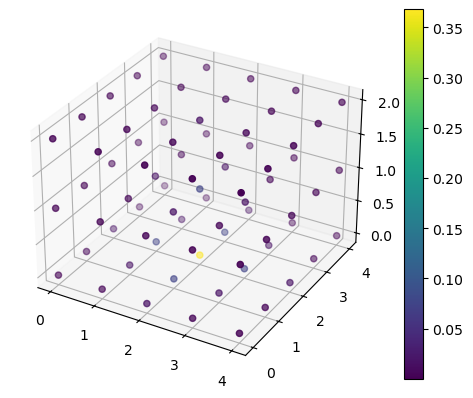

Tensors:


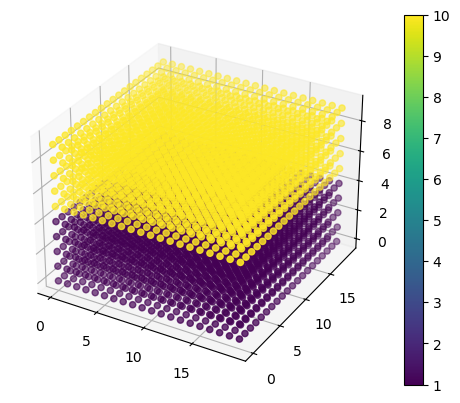

Smoothed Tensors:


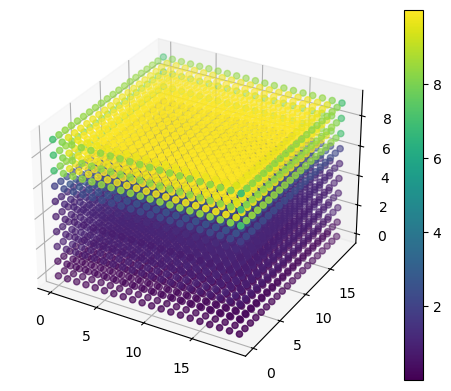

Smoothed Tensors sliced:


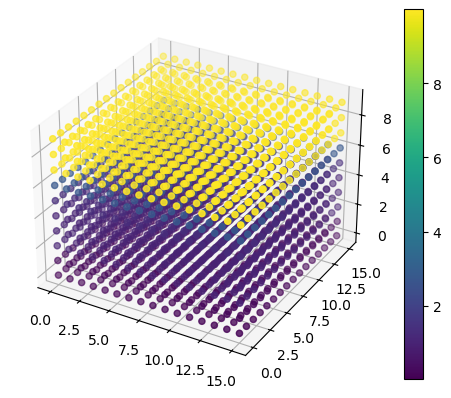

In [15]:
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot3D(tensor):
    # Créer les coordonnées pour la visualisation
    x = torch.arange(tensor.size(0))
    y = torch.arange(tensor.size(1))
    z = torch.arange(tensor.size(2))

    # Créer une grille pour X, Y, Z
    X, Y, Z = torch.meshgrid(x, y, z, indexing="ij")

    # Convertir les données en numpy pour matplotlib
    X_np = X.numpy()
    Y_np = Y.numpy()
    Z_np = Z.numpy()
    tensor_np = tensor.detach().numpy()

    # Visualisation avec matplotlib
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Tracer les points 3D avec un colormap viridis
    img = ax.scatter(X_np, Y_np, Z_np, c=tensor_np.flatten(), cmap='viridis')

    # Ajouter une barre de couleur
    fig.colorbar(img)

    plt.show()

alpha = 0.8
tensor_test = torch.tensor([1]*20*20*10).reshape(1,20,20,10)
tensor_test[...,-5:] = torch.Tensor([10]*20*20*5).reshape(1,20,20,5)
EMA = ExponentialMovingAverage(tensor_test, 
                         temporal_alpha=alpha, 
                         spatial_alpha=alpha, 
                         temporal_window_size = 3,
                         spatial_window_size = 5
                        )
smoothed_tensor_test = EMA.compute_ema(tensor_test)

print('Weights')
plot3D(EMA.conv.weight.squeeze())
print('Tensors:')
plot3D(tensor_test.squeeze())
print('Smoothed Tensors:')
plot3D(smoothed_tensor_test)
print('Smoothed Tensors sliced:')
plot3D(smoothed_tensor_test[2:-2,2:-2,:])

KeyboardInterrupt: 

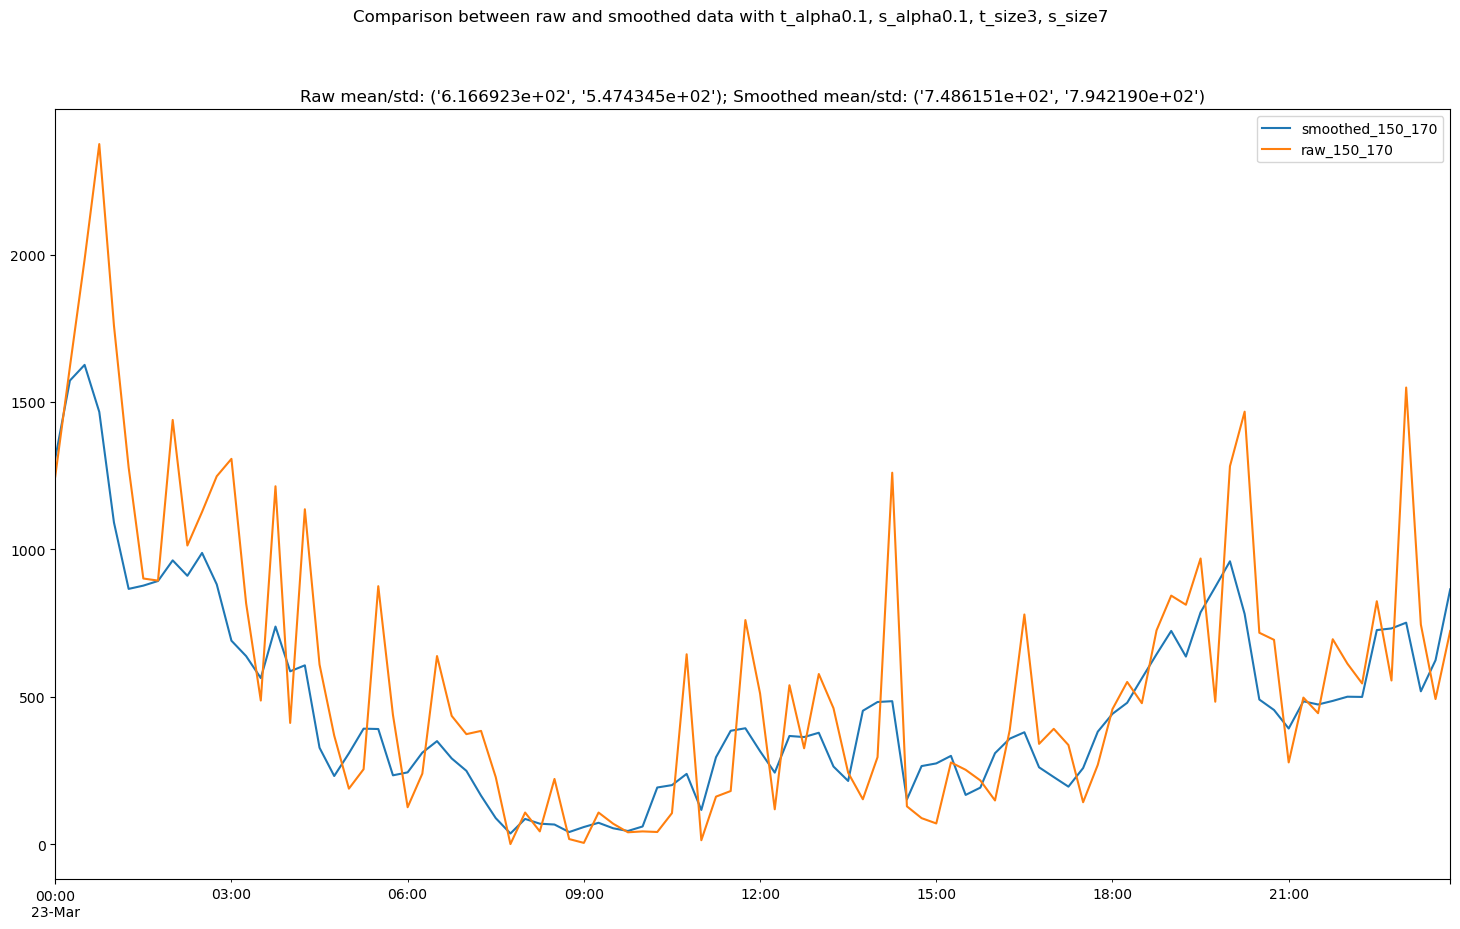

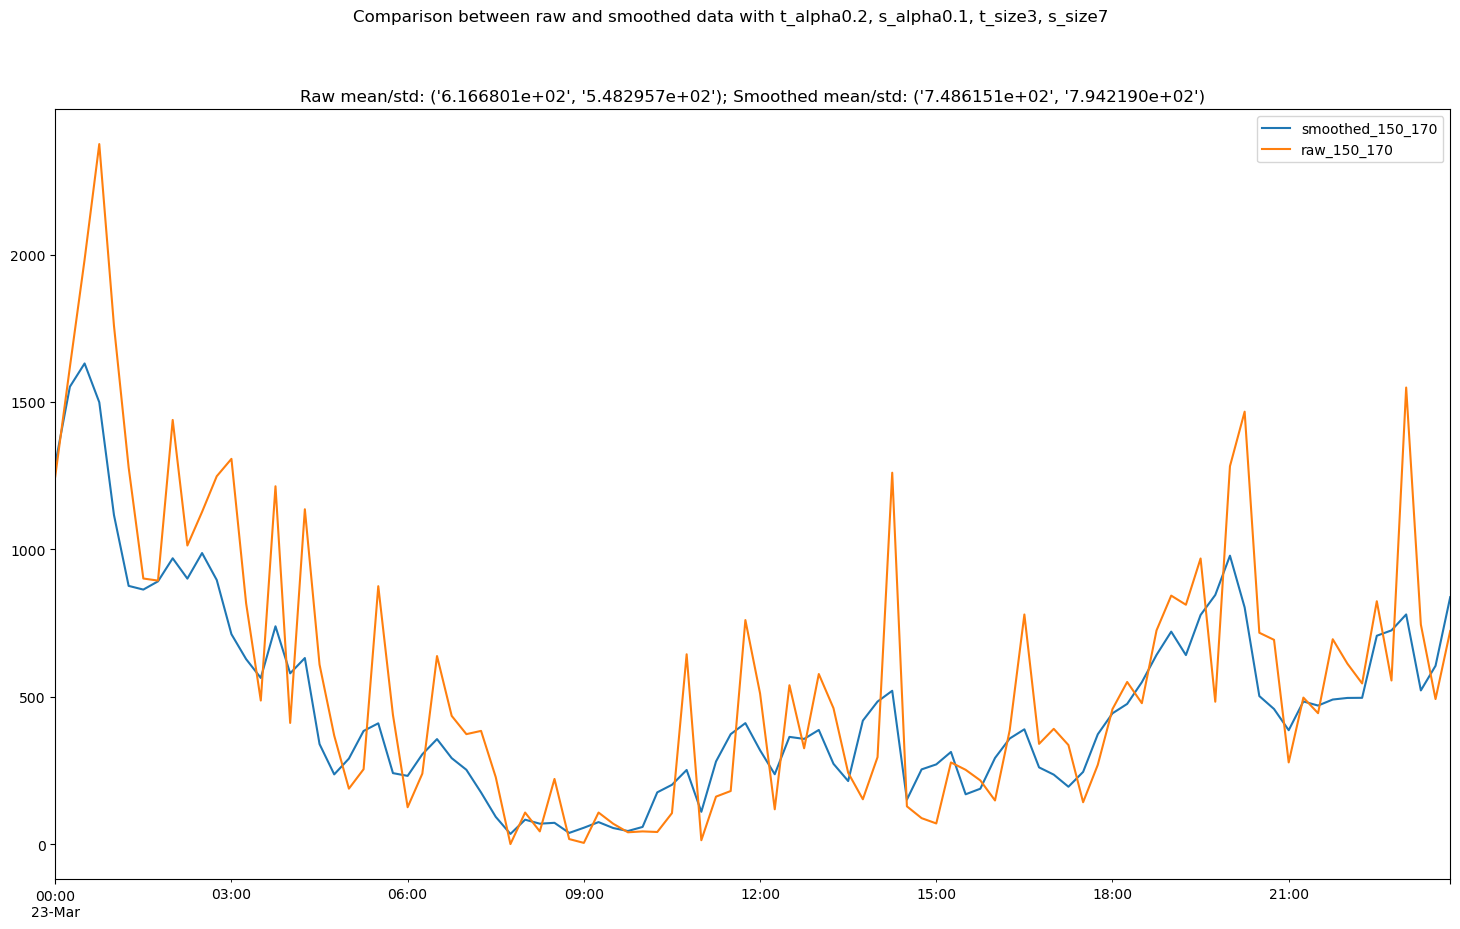

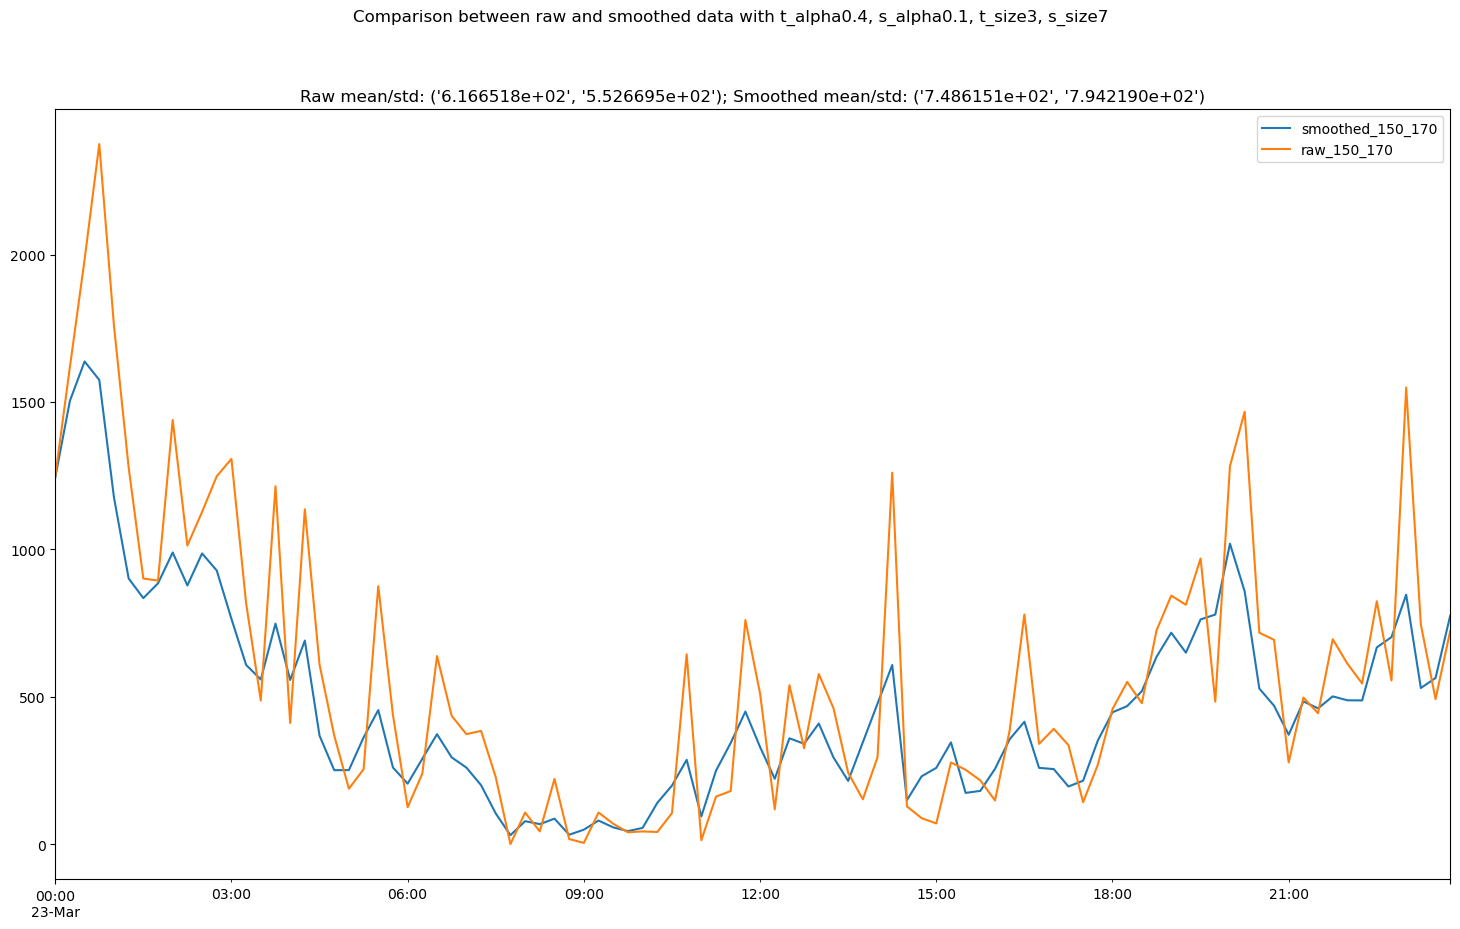

In [9]:
start = 96*7
ts_size = 96
H = 150
W = 170

t_alpha = 0.8
s_alpha = 0.1
t_size = 3
s_size = 7

for s_alpha in [0.1,0.2,0.4,0.9]:
    for t_alpha in [0.1,0.2,0.4,0.9]:
        EMA,smoothed_netmob = return_smoothed_netmob(netmob_T,t_alpha,s_alpha,t_size,s_size)
        ts_comparison_smoothed_and_raw(netmob_T,smoothed_netmob,start,ts_size,t_alpha,s_alpha,t_size,s_size,H,W)

In [ ]:
ts_size = 96*7
H,W = 150,170

pd.DataFrame({f'{H}_{W}150_170': netmob_T.permute(1,2,3,0)[0,150,170,:ts_size].detach().numpy(),
              '150_180': netmob_T.permute(1,2,3,0)[0,150,180,:ts_size].detach().numpy(),
              '150_190': netmob_T.permute(1,2,3,0)[0,150,190,:ts_size].detach().numpy(),
              '160_170': netmob_T.permute(1,2,3,0)[0,160,170,:ts_size].detach().numpy(),
              '160_180': netmob_T.permute(1,2,3,0)[0,160,180,:ts_size].detach().numpy(),
              '160_190': netmob_T.permute(1,2,3,0)[0,160,190,:ts_size].detach().numpy()
            },
            index = pd.date_range(start='03/16/2019', end='06/1/2019', freq='15min')[:ts_size]
            ).plot(figsize = (18,10))

#### 3D Visualisation :

In [7]:
'''Plot3D is available in ExponentialMovingAverage.py'''
plot3D(netmob_T.permute(1,2,3,0)[0,130:200,130:200,7*24:7*24+3])

# spatial_alpha = 0.3, t_alpha = 0.8, spatial_window_size = 7, temporal_window_size = 3
plot3D(smoothed_netmob[0,130:200,130:200,7*24:7*24+3])

NameError: name 'plot3D' is not defined

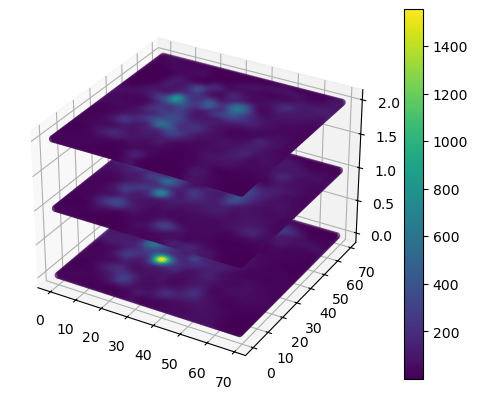

In [255]:
# spatial_alpha = 0.4, spatial_window_size = 5
plot3D(smoothed_netmob[0,130:200,130:200,7*24:7*24+3])

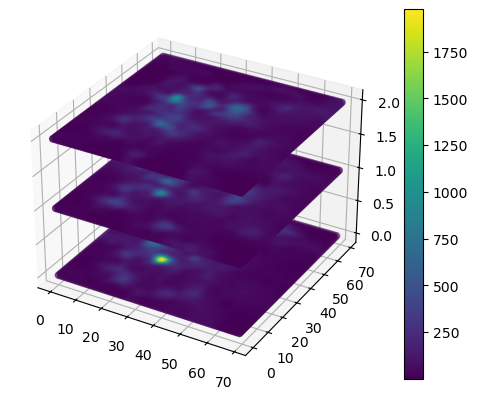

In [241]:
# spatial_alpha = 0.8, spatial_window_size = 5
plot3D(smoothed_netmob[0,130:200,130:200,7*24:7*24+3])

### For a selected app, Build NetMob Intensity Video [T,H,W]:

In [ ]:
if torch.cuda.is_available():
    folder_save_path = '../../Visualisation_NetMob_Subway'
else:
    folder_save_path = '../../../Visualisation_NetMob_Subway'

restricted = True
rotation = True
smooth = True 
start = 0  # 0   # 6*4
end = 4*24*7  # 4*24*77 # 8*4
window_size = 3
load_npz = True
week = 1

for week in range(10):
    for window_size in [None,3,5]:
        smooth = False if window_size is None else True
        for app in selected_apps:
            print(f'\nTackling app: {app}')
            if load_npz:    
                tensor_sparse = scipy.sparse.load_npz(f'{save_folder_tmps}/{app}_video_week{week}.npz')
                netmob_plot = torch.from_numpy(tensor_sparse.toarray().reshape(-1, image_dim[0], image_dim[1]))
            else:
                pos_app_within_tensor = [pos_i for pos_i,app_i in enumerate(selected_apps) if app_i == app][0]
                netmob_plot  = netmob_T[:,pos_app_within_tensor,:,:].clone().detach()

            #save_path = f"{folder_save_path}/gif_netmob/{app}_intensity_video_2D_start{start}_end{end}.mp4"
            save_path = f"{folder_save_path}/gif_netmob/{app}_week{week}_intensity_video_2D.mp4"

            if smooth : 
                conv,netmob_plot = temporal_moving_average(netmob_plot, window_size=window_size)
                #save_path = f"gif_netmob/smoothed{window_size}_{app}_intensity_video_2D_start{start}_end{end}.mp4"
                save_path = f"{folder_save_path}/gif_netmob/smoothed{window_size}_{app}_week{week}_intensity_video_2D.mp4"

            create_intensity_video(netmob_plot,start, end, 
                                save_path=save_path,
                                plot_3d=False, figsize=(14, 14), 
                                highlight_coords=[coords_A,coords_B,coords_C,coords_D],
                                restricted=restricted,
                                rotation = rotation,
                                app = app)



Tackling app: Uber


## Print Temporal Series associated to a cell:

<Axes: >

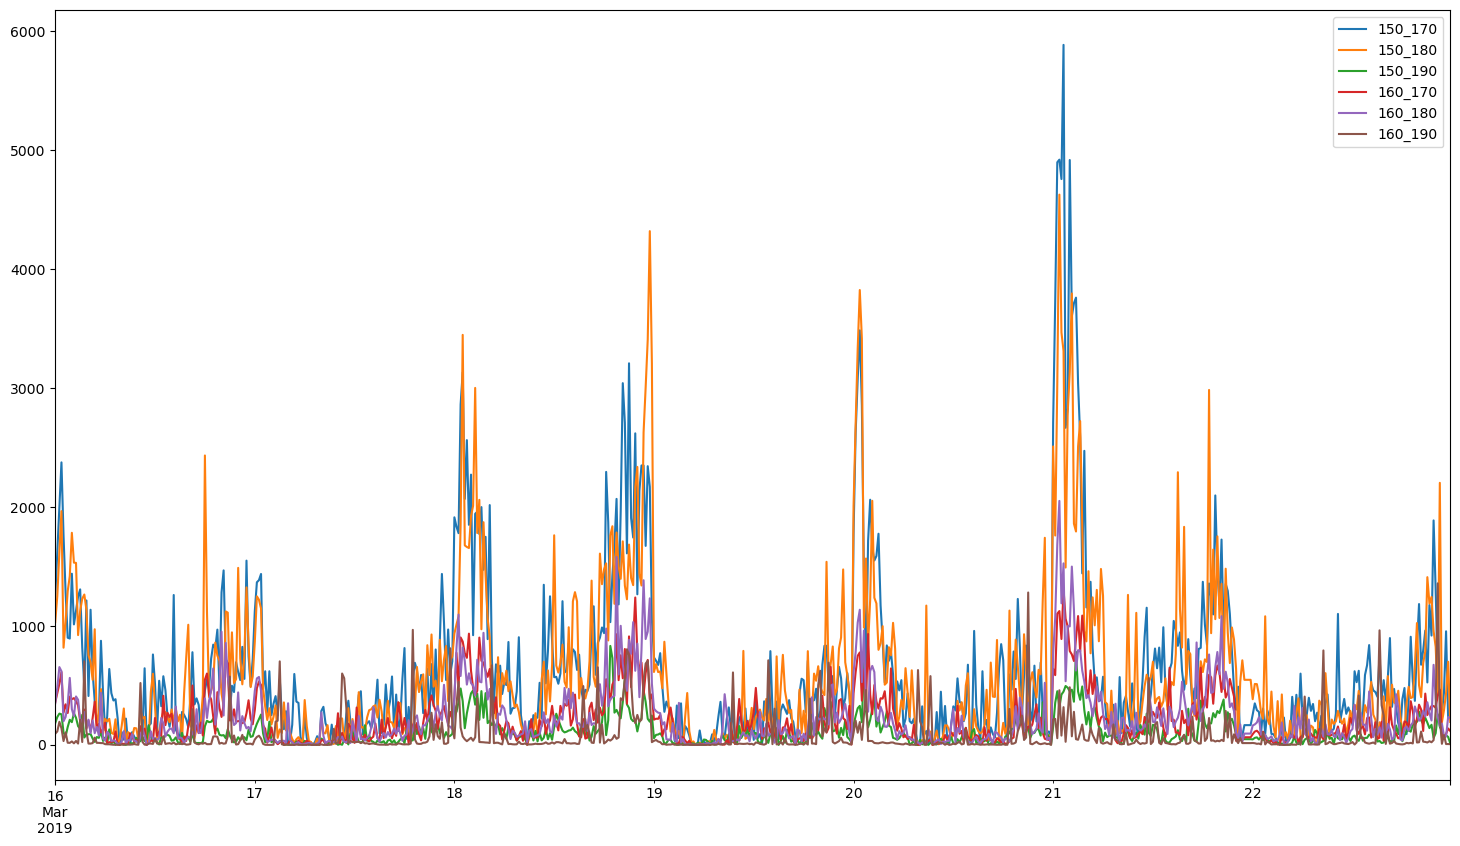

In [252]:
ts_size = 96*7
pd.DataFrame({'150_170': netmob_T.permute(1,2,3,0)[0,150,170,:ts_size].detach().numpy(),
              '150_180': netmob_T.permute(1,2,3,0)[0,150,180,:ts_size].detach().numpy(),
              '150_190': netmob_T.permute(1,2,3,0)[0,150,190,:ts_size].detach().numpy(),
              '160_170': netmob_T.permute(1,2,3,0)[0,160,170,:ts_size].detach().numpy(),
              '160_180': netmob_T.permute(1,2,3,0)[0,160,180,:ts_size].detach().numpy(),
              '160_190': netmob_T.permute(1,2,3,0)[0,160,190,:ts_size].detach().numpy()
            },
            index = pd.date_range(start='03/16/2019', end='06/1/2019', freq='15min')[:ts_size]
            ).plot(figsize = (18,10))

## spatial-alpha = 0.4, spatial window = 5, temporal-alpha = 0.8, temporal window  = 3

<Axes: >

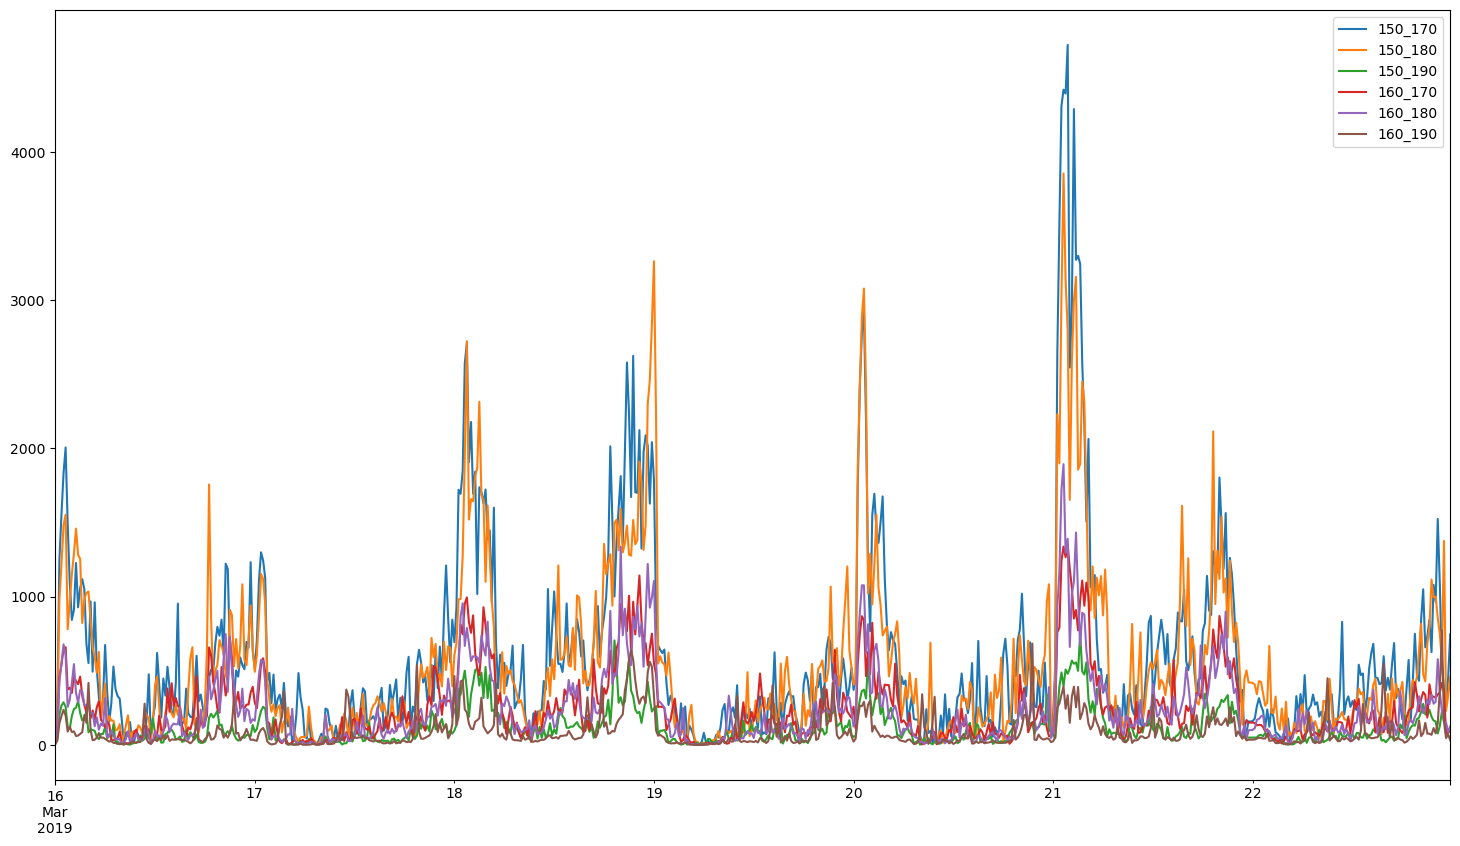

In [257]:
ts_size = 96*7
pd.DataFrame({'150_170': smoothed_netmob[0,150,170,:ts_size].detach().numpy(),
              '150_180': smoothed_netmob[0,150,180,:ts_size].detach().numpy(),
              '150_190': smoothed_netmob[0,150,190,:ts_size].detach().numpy(),
              '160_170': smoothed_netmob[0,160,170,:ts_size].detach().numpy(),
              '160_180': smoothed_netmob[0,160,180,:ts_size].detach().numpy(),
              '160_190': smoothed_netmob[0,160,190,:ts_size].detach().numpy()
            },
            index = pd.date_range(start='03/16/2019', end='06/1/2019', freq='15min')[:ts_size]
            ).plot(figsize = (18,10))

## spatial-alpha = 0.8, spatial window = 5, temporal-alpha = 0.8, temporal window  = 3

In [4]:
ts_size = 96*7
pd.DataFrame({'150_170': smoothed_netmob[0,150,170,:ts_size].detach().numpy(),
              '150_180': smoothed_netmob[0,150,180,:ts_size].detach().numpy(),
              '150_190': smoothed_netmob[0,150,190,:ts_size].detach().numpy(),
              '160_170': smoothed_netmob[0,160,170,:ts_size].detach().numpy(),
              '160_180': smoothed_netmob[0,160,180,:ts_size].detach().numpy(),
              '160_190': smoothed_netmob[0,160,190,:ts_size].detach().numpy()
            },
            index = pd.date_range(start='03/16/2019', end='06/1/2019', freq='15min')[:ts_size]
            ).plot(figsize = (18,10))

NameError: name 'smoothed_netmob' is not defined

<AxesSubplot:>

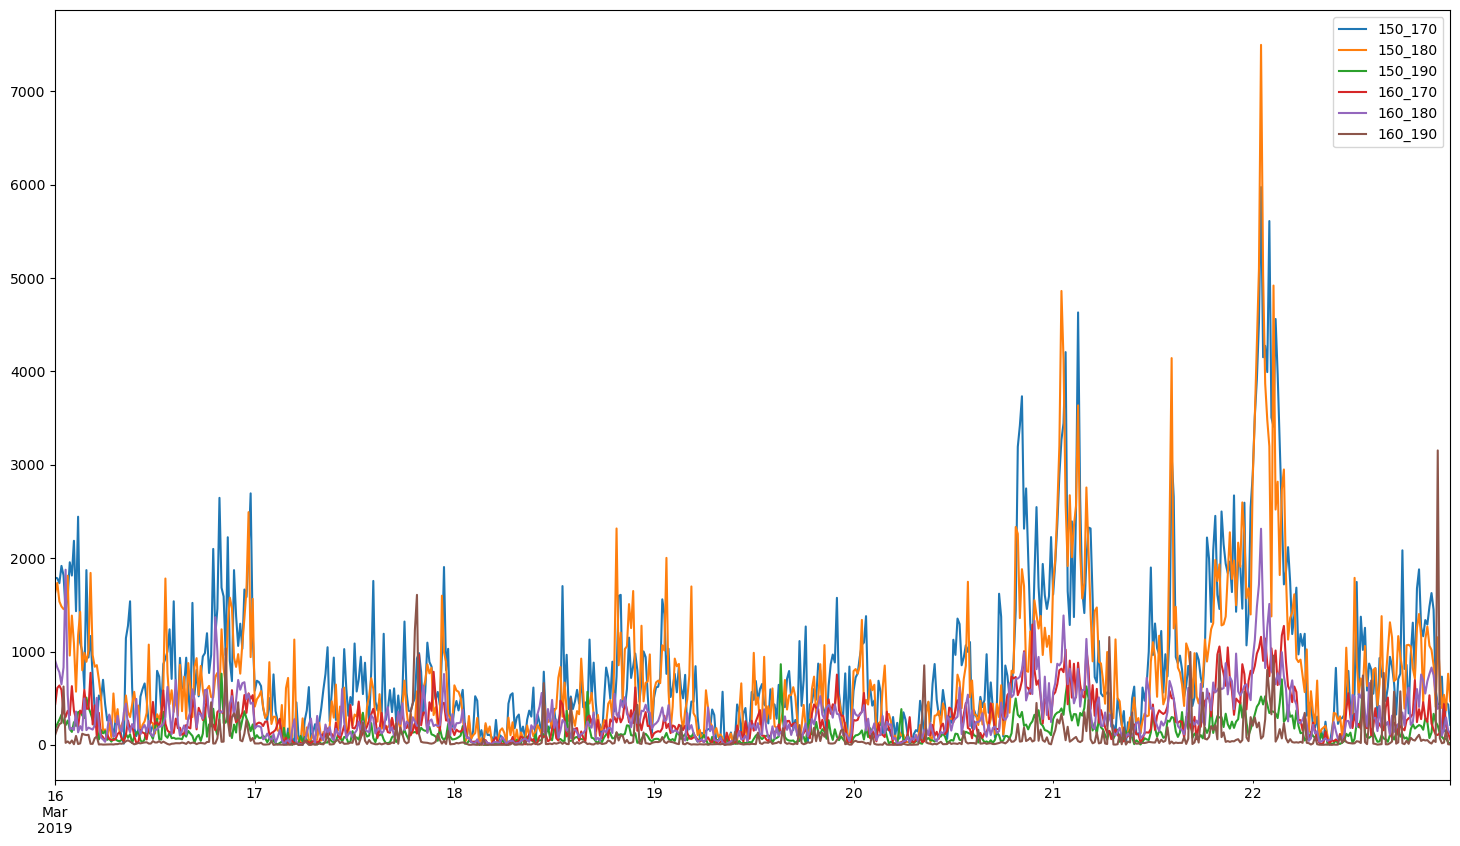

In [22]:
tensor_sparse = scipy.sparse.load_npz(f'{save_folder_tmps}/{app}_video_week{week}.npz')
netmob_plot = torch.from_numpy(tensor_sparse.toarray().reshape(-1, image_dim[0], image_dim[1]))
pd.DataFrame({'150_170': netmob_plot[:,150,170],
              '150_180': netmob_plot[:,150,180],
              '150_190': netmob_plot[:,150,190],
              '160_170': netmob_plot[:,160,170],
              '160_180': netmob_plot[:,160,180],
              '160_190': netmob_plot[:,160,190]
            },
            index = pd.date_range(start='03/16/2019', end='06/1/2019', freq='15min')[:netmob_plot.size(0)]
            ).plot(figsize = (18,10))

In [37]:
# Set data and path to save: 
save_folder_tmps = '../../../../data/data_tmps/smoothed_EMA_netmob/t_alpha08_t_window3_s_window7_s_alpha02_/'
if not os.path.exists(save_folder_tmps):
    os.mkdir(save_folder_tmps)
netmob_data_to_save = smoothed_netmob.permute(3,0,1,2).size()

# Save Every single data:
if True : 
    # Save tensor 
    for k,app in enumerate(selected_apps):
        T_to_save = netmob_data_to_save[:,k,:,:].clone().detach()  # [T,H,W]
        for week in range(11):
            start,end = week*(96*7),(week+1)*(96*7)
            T_plot = T_to_save[start:end] #[672,H,W]
            # Convert to sparse tensor 
            tensor_sparse = scipy.sparse.csr_matrix(T_plot.numpy().reshape(-1, T_plot.size(1)*T_plot.size(2)))  
            # Save in npz format
            scipy.sparse.save_npz(f'{save_folder_tmps}/{app}_video_week{week}.npz', tensor_sparse)
            
            
    # save coords and apps :
    coords_all_lanes = {'A':coords_A, 'B':coords_B,'C':coords_C,'D':coords_D}
    
    metadata = {'coords_all_lanes': coords_all_lanes,
                'selected_apps': selected_apps,
                'image_dim': [T_plot.size(1),T_plot.size(2)],
               }
    pickle.dump(metadata,open(f'{save_folder_tmps}/metadata.pkl','wb'))
    

# Load saved tensor 
if True: 
    metadata = pickle.load(open(f'{save_folder_tmps}/metadata.pkl','rb'))
    image_dim = metadata['image_dim']
    selected_apps = metadata['selected_apps']
    coords_A = metadata['coords_all_lanes']['A']
    coords_B = metadata['coords_all_lanes']['B']
    coords_C = metadata['coords_all_lanes']['C']
    coords_D = metadata['coords_all_lanes']['D']
    
    tensor_sparse = scipy.sparse.load_npz(f'{save_folder_tmps}/Deezer_video_week1.npz')
    tensor_loaded = torch.from_numpy(tensor_sparse.toarray().reshape(-1, image_dim[0], image_dim[1]))
    #t_test = torch.load(f'{save_folder_tmps}/Deezer_video_week1.pt', weights_only=True)
    print('Size of tensor: ',tensor_loaded.size())
    

Size of tensor:  torch.Size([672, 263, 287])


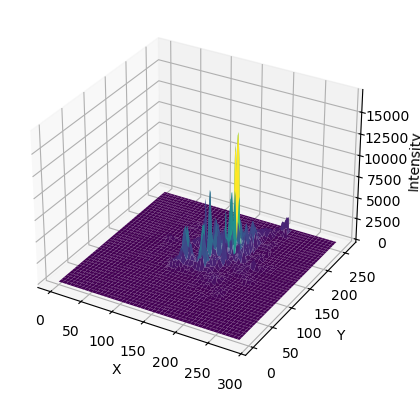

In [181]:
plot_3d_intensity(netmob_T[8*4,:,:])